In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
diabetes=pd.read_csv('data/diabetes_data.csv')
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female


Pregnancies — количество беременностей.

Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе.

BloodPressure — диастолическое артериальное давление (мм рт. ст.).

SkinThickness — толщина кожной складки трицепса (мм).

Insulin — двухчасовой сывороточный инсулин (ме Ед/мл).

BMI — индекс массы тела (\(\frac{вес\ в\ кг}{(рост\ в\ м)^2}\)).

DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости).

Age — возраст.

Outcome — наличие диабета (0 — нет, 1 — да).

In [42]:
dupl_columns = list(df.columns)

mask = df.duplicated(subset=dupl_columns)
diabeteslicates = df[mask]
print(f'Число найденных дубликатов: {diabeteslicates.shape[0]}')

Число найденных дубликатов: 10


In [43]:
diabetes_dedupped = df.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {diabetes_dedupped.shape[0]}')

Результирующее число записей: 768


In [44]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in diabetes_dedupped.columns:
    #наибольшая относительная частота в признаке
    top_freq = diabetes_dedupped[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = diabetes_dedupped[col].nunique() / diabetes_dedupped[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

Gender: 100.0% одинаковых значений


In [45]:
df = diabetes_dedupped.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {df.shape[1]}')

Результирующее число признаков: 9


In [46]:
# пропуски с помощью isnull()
cols_null_percent = df.isnull().mean().round(2)
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols] = df[cols].replace({'0':np.nan, 0:np.nan})
propuski_Insulin = df["Insulin"].isnull().mean().round(2)
print(propuski_Insulin)
thresh = df.shape[0]*0.7
df = df.dropna(thresh=thresh, axis=1)
print(df.shape[1])
n_priznakov = df.shape[1]
df = df.dropna(thresh=n_priznakov-2, axis=0)
print(df.shape[0])

Series([], dtype: float64)

0.49
8
761


In [47]:
display(df.isnull().mean())

Pregnancies                 0.000000
Glucose                     0.006570
BloodPressure               0.036794
SkinThickness               0.289093
BMI                         0.005256
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
dtype: float64

In [48]:
null_data = df.isnull().sum()
cols = null_data[null_data>0].index
for col in cols:
    df[col] = df[col].fillna(df[col].median())
print(df['SkinThickness'].mean().round(1))
#выводим результирующую долю пропусков
display(df.isnull().mean())
display(df['SkinThickness'].mean())

29.1


Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

29.109067017082786

In [49]:
df['SkinThickness'].describe()

count    761.000000
mean      29.109067
std        8.831608
min        7.000000
25%       25.000000
50%       29.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64

In [50]:
#display(information_diabetes[information_diabetes['SkinThickness'] <= 8])

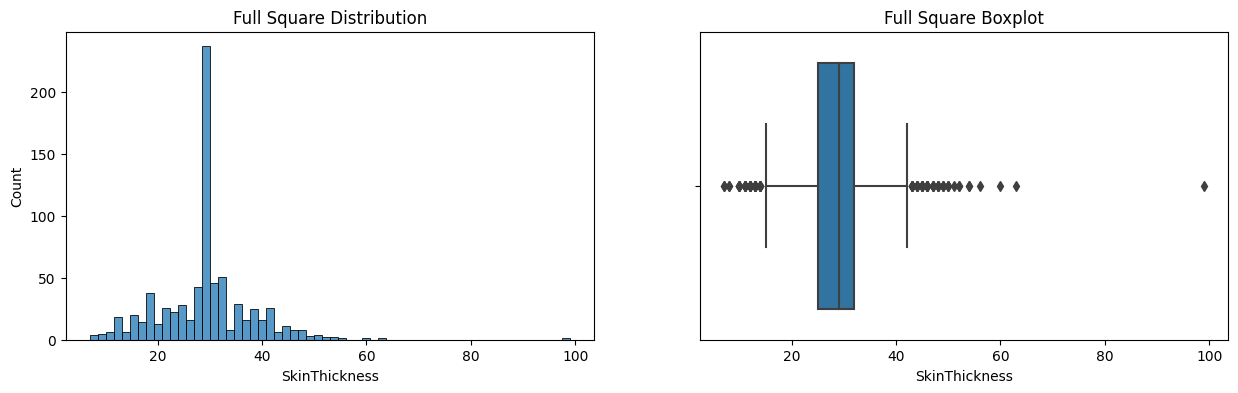

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data= df, x='SkinThickness', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data= df, x='SkinThickness', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

In [52]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [53]:
outliers, cleaned = outliers_iqr_mod(df, 'SkinThickness')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 87
Результирующее число записей: 674


In [54]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [57]:
outliers, cleaned = outliers_z_score_mod(df, 'SkinThickness', log_scale=False)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 4
Результирующее число записей: 757


In [56]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned
outliers, _ = outliers_iqr_mod(diabetes, 'DiabetesPedigreeFunction')
outliers_log, _ = outliers_iqr_mod(diabetes, 'DiabetesPedigreeFunction', log_scale=True)
print(outliers.shape[0])
print(outliers_log.shape[0])
print(outliers.shape[0] - outliers_log.shape[0])


29
0
29
